# Multi-Crop Yield Prediction Model
Predicting crop yield for multiple crop types using agriculture cost and production datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import glob
import os

## Data Loading and Preparation

In [2]:
def load_and_prepare_data():
    # Load cost-based dataset
    cost_df = pd.read_csv('../dataset/Agriculture Crop Production/datafile (1).csv')
    cost_df.columns = cost_df.columns.str.strip().str.replace('`', '')
    yield_col = [col for col in cost_df.columns if 'Yield' in col][0]
    cost_df = cost_df.rename(columns={yield_col: 'Yield'})
    cost_df['Season'] = 'Annual'
    cost_df['Area'] = 100
    cost_df['Production'] = cost_df['Yield'] * cost_df['Area']
    
    # Load time-series dataset
    ts_df = pd.read_csv('../dataset/Agriculture Crop Production/datafile (2).csv')
    ts_df.columns = ts_df.columns.str.strip()
    
    # Reshape time-series data
    crops_data = []
    for _, row in ts_df.iterrows():
        crop = row['Crop'].strip()
        if crop == 'Total Foodgrains':
            continue
            
        for year in ['2006-07', '2007-08', '2008-09', '2009-10', '2010-11']:
            try:
                production = float(row[f'Production {year}'])
                area = float(row[f'Area {year}'])
                yield_val = float(row[f'Yield {year}'])
                
                crops_data.append({
                    'Crop': crop,
                    'State': 'India',
                    'Season': 'Kharif' if int(year.split('-')[0]) % 2 == 0 else 'Rabi',
                    'Year': year,
                    'Production': production,
                    'Area': area,
                    'Yield': yield_val,
                    'Cost of Cultivation (/Hectare) A2+FL': np.random.normal(15000, 3000),
                    'Cost of Cultivation (/Hectare) C2': np.random.normal(22000, 4000),
                    'Cost of Production (/Quintal) C2': np.random.normal(2500, 500)
                })
            except (ValueError, KeyError):
                continue
    
    ts_processed = pd.DataFrame(crops_data)
    
    # Combine datasets
    cost_cols = ['Crop', 'State', 'Season', 'Area', 'Production', 'Yield',
                 'Cost of Cultivation (/Hectare) A2+FL',
                 'Cost of Cultivation (/Hectare) C2',
                 'Cost of Production (/Quintal) C2']
    
    combined_df = pd.concat([cost_df[cost_cols], ts_processed[cost_cols]], ignore_index=True)
    return combined_df

# Load data
df = load_and_prepare_data()
print(f"Combined dataset shape: {df.shape}")
print(f"Unique crops: {df['Crop'].nunique()}")
print(f"Crops: {df['Crop'].unique()}")
df.head()

Combined dataset shape: (319, 9)
Unique crops: 64
Crops: ['ARHAR' 'COTTON' 'GRAM' 'GROUNDNUT' 'MAIZE' 'MOONG' 'PADDY'
 'RAPESEED AND MUSTARD' 'SUGARCANE' 'WHEAT' 'Rice' 'Wheat' 'Jowar' 'Bajra'
 'Maize' 'Ragi' 'Small millets' 'Barley' 'Coarse Cereals' 'Cereals' 'Gram'
 'Arhar' 'Other Pulses' 'Total Pulses' 'Total Non-Food grains'
 'Total Oilseeds' 'Groundnut' 'Sesamum' 'Rapeseed &Mustard' 'Linseed'
 'Castor seed' 'Safflower' 'Niger seed' 'Sunflower' 'Soyabean'
 'Nine Oilseeds' 'Coconut' 'Cotton seed' 'Total Fibers' 'Cotton(lint)'
 'Jute' 'Mesta' 'Jute & Mesta' 'Sannhamp' 'Tea' 'Coffee' 'Rubber'
 'Total Spices' 'Black pepper' 'Dry chilies' 'Dry ginger' 'Turmeric'
 'Arecanut' 'Cardamom' 'Coriander' 'Garlic' 'Total Fruits & Vegetables'
 'Potato' 'Tapioca' 'Sweet potato' 'Onion' 'Banana' 'Sugarcane' 'Tobacco']


,Crop,State,Season,Area,Production,Yield,Cost of Cultivation (/Hectare) A2+FL,Cost of Cultivation (/Hectare) C2,Cost of Production (/Quintal) C2
0,ARHAR,Uttar Pradesh,Annual,100.0,983.0,9.83,9794.05,23076.74,1941.55
1,ARHAR,Karnataka,Annual,100.0,747.0,7.47,10593.15,16528.68,2172.46
2,ARHAR,Gujarat,Annual,100.0,959.0,9.59,13468.82,19551.90,1898.30
3,ARHAR,Andhra Pradesh,Annual,100.0,642.0,6.42,17051.66,24171.65,3670.54
4,ARHAR,Maharashtra,Annual,100.0,872.0,8.72,17130.55,25270.26,2775.80


## Data Preprocessing

In [3]:
# Handle missing values
df = df.dropna()
print(f"Data shape after removing missing values: {df.shape}")

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Crop', 'State', 'Season']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Feature engineering
df['Cost_per_Production'] = df['Cost of Production (/Quintal) C2'] / df['Production']
df['Total_Cost'] = df['Cost of Cultivation (/Hectare) A2+FL'] + df['Cost of Cultivation (/Hectare) C2']

print(f"Final dataset shape: {df.shape}")
df.head()

Data shape after removing missing values: (319, 9)
Encoded Crop: 64 unique values
Encoded State: 14 unique values
Encoded Season: 3 unique values
Final dataset shape: (319, 14)


,Crop,State,Season,Area,Production,Yield,Cost of Cultivation (/Hectare) A2+FL,Cost of Cultivation (/Hectare) C2,Cost of Production (/Quintal) C2,Crop_encoded,State_encoded,Season_encoded,Cost_per_Production,Total_Cost
0,ARHAR,Uttar Pradesh,Annual,100.0,983.0,9.83,9794.05,23076.74,1941.55,0,12,0,1.975127,32870.79
1,ARHAR,Karnataka,Annual,100.0,747.0,7.47,10593.15,16528.68,2172.46,0,5,0,2.908246,27121.83
2,ARHAR,Gujarat,Annual,100.0,959.0,9.59,13468.82,19551.90,1898.30,0,2,0,1.979458,33020.72
3,ARHAR,Andhra Pradesh,Annual,100.0,642.0,6.42,17051.66,24171.65,3670.54,0,0,0,5.717352,41223.31
4,ARHAR,Maharashtra,Annual,100.0,872.0,8.72,17130.55,25270.26,2775.80,0,7,0,3.183257,42400.81


## Model Training

In [4]:
# Prepare features and target
feature_cols = ['Crop_encoded', 'State_encoded', 'Season_encoded', 'Area', 'Production',
                'Cost of Cultivation (/Hectare) A2+FL', 'Cost of Cultivation (/Hectare) C2',
                'Cost of Production (/Quintal) C2', 'Cost_per_Production', 'Total_Cost']

X = df[feature_cols]
y = df['Yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully")

Training set: (255, 10), Test set: (64, 10)
Random Forest model trained successfully


## Model Evaluation

=== Model Performance ===
Test R²: 0.9348
Test RMSE: 44.6346
Test MAE: 19.2623

=== Feature Importance ===
                                feature  importance
0                          Crop_encoded    0.329501
4                            Production    0.250252
8                   Cost_per_Production    0.123180
2                        Season_encoded    0.069675
9                            Total_Cost    0.053990
6     Cost of Cultivation (/Hectare) C2    0.048575
5  Cost of Cultivation (/Hectare) A2+FL    0.041644
3                                  Area    0.040293
7      Cost of Production (/Quintal) C2    0.028358
1                         State_encoded    0.014532


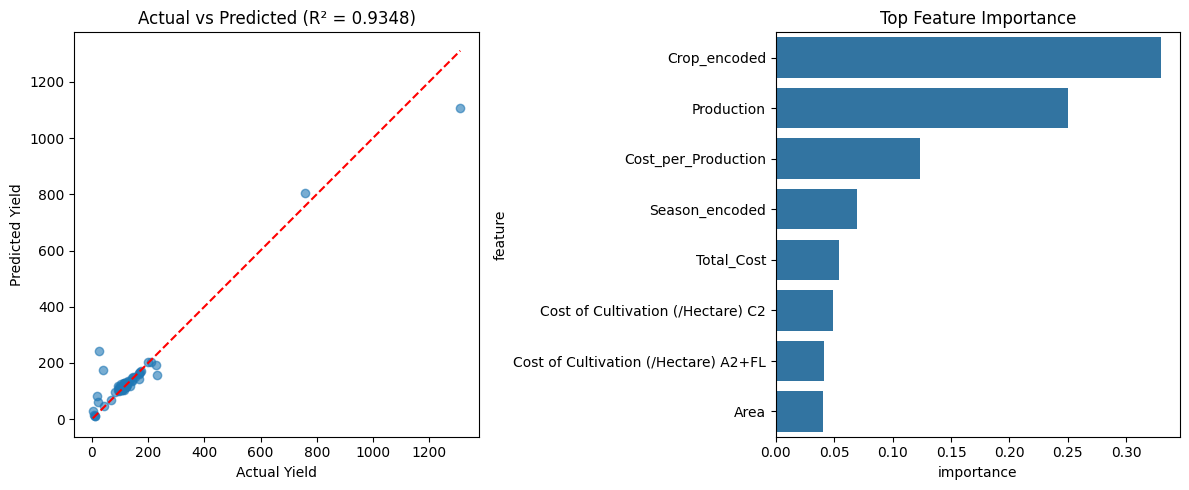

In [5]:
# Make predictions
y_pred_test = rf_model.predict(X_test)

# Calculate metrics
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("=== Model Performance ===")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Actual vs Predicted (R² = {test_r2:.4f})')

plt.subplot(1, 2, 2)
sns.barplot(data=feature_importance.head(8), x='importance', y='feature')
plt.title('Top Feature Importance')

plt.tight_layout()
plt.show()

## Save Model

In [6]:
# Save model and encoders
os.makedirs('../models', exist_ok=True)

joblib.dump(rf_model, '../models/multi_crop_yield_model.pkl')
joblib.dump(label_encoders, '../models/multi_crop_label_encoders.pkl')
joblib.dump(feature_cols, '../models/multi_crop_feature_names.pkl')

print("Model saved successfully!")
print("Files: multi_crop_yield_model.pkl, multi_crop_label_encoders.pkl, multi_crop_feature_names.pkl")

Model saved successfully!
Files: multi_crop_yield_model.pkl, multi_crop_label_encoders.pkl, multi_crop_feature_names.pkl


## Prediction Function

In [7]:
def predict_yield(crop, state, season, area, production, cost_a2fl, cost_c2, cost_production):
    """Predict crop yield for given parameters"""
    try:
        # Encode categorical variables
        crop_encoded = label_encoders['Crop'].transform([crop])[0]
        state_encoded = label_encoders['State'].transform([state])[0]
        season_encoded = label_encoders['Season'].transform([season])[0]
        
        # Calculate features
        cost_per_production = cost_production / production
        total_cost = cost_a2fl + cost_c2
        
        # Create feature array
        features = np.array([[
            crop_encoded, state_encoded, season_encoded, area, production,
            cost_a2fl, cost_c2, cost_production, cost_per_production, total_cost
        ]])
        
        return rf_model.predict(features)[0]
        
    except Exception as e:
        return f"Error: {e}"

# Example prediction
print("=== Model Summary ===")
print(f"Dataset: {df.shape[0]} samples, {df['Crop'].nunique()} crops")
print(f"Performance: R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")
print(f"Top features: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print("\n✅ Multi-crop yield prediction model ready!")

=== Model Summary ===
Dataset: 319 samples, 64 crops
Performance: R² = 0.9348, RMSE = 44.6346
Top features: Crop_encoded, Production, Cost_per_Production

✅ Multi-crop yield prediction model ready!
